In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from cartiflette import carti_download


Téléchargement réussi !
        SEXE  AGE       RAGE1        RAGE2        RAGE3          AGGLOIFOP0  \
0  Une femme   25  De25a34ans  De25a34ans1  De15a34ans2                UU05   
1   Un homme   64  De50a64ans  De50a64ans1    De50aPlus                UU02   
2  Une femme   35  De35a49ans  De35a49ans1  De35a49ans2  Hors unité urbaine   
3  Une femme   65  De65a74ans    De65aPlus    De50aPlus                UU06   
4   Un homme   40  De35a49ans  De35a49ans1  De35a49ans2                UU06   

  jz2cdep  jz2ctypcom  jz2ctailcom AGGLOIFOP0.1  ...  \
0      42           1            9         TUU5  ...   
1      44           3            3         TUU2  ...   
2      70           6            1         TUU0  ...   
3      64           1           10         TUU6  ...   
4      30           1           11         TUU6  ...   

                                            RS18_r12  \
0                                                NaN   
1                                                NaN

/tmp/ipykernel_52277/726135693.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.replace({"#NUL!": np.nan, "": np.nan, " ": np.nan}, inplace=True)
/tmp/ipykernel_52277/726135693.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # retirer les espaces au début et à la fin des string pour le recodage au cas où


   sexe  age  plusde10000habitants      type_commune     taille_commune  \
0     0   25                     0       VilleCentre   De30000a49999hab   
1     1   64                     0  BanlieueNVInterm     De2000a3499hab   
2     0   35                     0             Rural     Moinsde1000hab   
3     0   65                     1       VilleCentre   De50000a99999hab   
4     1   40                     1       VilleCentre  De100000habEtPlus   

            departement  province                 region  \
0                 LOIRE         1     AuvergneRhoneAlpes   
1       LOIREATLANTIQUE         1         PaysDeLaLoire1   
2            HAUTESAONE         1  BourgogneFrancheComte   
3  PYRENNEESATLANTIQUES         1     NouvelleAquitaine1   
4                  GARD         1             Occitanie1   

                                  situation_actuelle  \
0  Vous exercez une activité professionnelle (act...   
1  Vous exercez une activité professionnelle (act...   
2  Vous exercez une 

<Axes: >

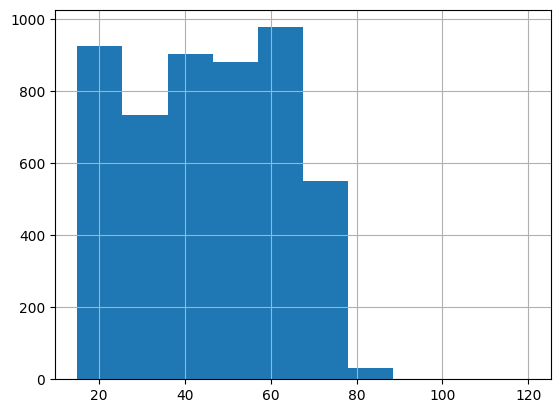

In [ ]:
# -------------------------------
# Téléchargement du fichier
# -------------------------------
url = "https://www.data.gouv.fr/api/1/datasets/r/aff9d702-db6d-46e5-8416-c032d8b9d89d"

response = requests.get(url)

if response.status_code == 200:
    with open("data_arcom.xlsx", "wb") as file:
        file.write(response.content)
    print("Téléchargement réussi !")
else:
    print("Erreur :", response.status_code)

df_brut = pd.read_excel("data_arcom.xlsx")
print(df_brut.head())
obs = df_brut.shape[0]
print(f"Nombre d'observations : {obs}")


In [ ]:
variables = [
    "SEXE", "AGE", "AGGLOIFOP2", "TYPCOM", "TAILCOM", "DPT", "REG3", "REG13", 
    "SITI", "PPIA", "RECPPIA", "STCA", "STATUT", "FOYER", 
    #Q1 quel produit avez-vous consommé de manière dématérialisée ces 12 derniers mois ?
    "Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_5", "Q1_6", "Q1_7", "Q1_8", "Q1_9", "Q1_10", "Q1_11", 
    #Q2 : à quelle fréquence ?
    "Q2_r1", "Q2_r2", "Q2_r3", "Q2_r4", "Q2_r5", "Q2_r6", "Q2_r7", "Q2_r8", "Q2_r9", "Q2_r10", "Q2_r11", 
    #Q2BIS : regardez-vous des vidéos de courtes durée proposées par Youtube?
    "Q2BIS",
    #Q3 : consommation légale ? (globalité)
    "Q3",
    #Q4 : consommation légale ? globalité dans le cadre des activités proposées question1
    "Q4",
    #Q5_r : consommation légale pour chaque activité
    "Q5_r1", "Q5_r2", "Q5_r3", "Q5_r4", "Q5_r5", "Q5_r6", "Q5_r7", "Q5_r8", "Q5_r9", "Q5_r10", "Q5_r11", 
    #Q6 : fréquence de conso illégale
    "Q6_r1", "Q6_r2", "Q6_r3", "Q6_r4", "Q6_r5", "Q6_r6", "Q6_r7", "Q6_r8", "Q6_r9", "Q6_r10", "Q6_r11", 
    #QBOL14 : comment découvrez-vous de nouveaux films ?
    "QBOL14_1", "QBOL14_2", "QBOL14_3", "QBOL14_4", "QBOL14_5", "QBOL14_6", "QBOL14_7", "QBOL14_8", "QBOL14_9", 
    #QBU1 : consommation payante ou gratuite ?
    "QBU1_r1", "QBU1_r2", "QBU1_r3", "QBU1_r4", "QBU1_r5", "QBU1_r6", "QBU1_r7", "QBU1_r8", "QBU1_r9", "QBU1_r10", "QBU1_r11", 
    #QBU7 : 3 principales raisons de ne pas consommer légalement
    "QBU7_r1_c1", "QBU7_r2_c1", "QBU7_r3_c1", "QBU7_r4_c1", "QBU7_r5_c1", "QBU7_r6_c1", "QBU7_r7_c1", "QBU7_r8_c1", "QBU7_r9_c1", "QBU7_r10_c1", "QBU7_r11_c1", "QBU7_r12_c1", "QBU7_r13_c1", "QBU7_r14_c1", "QBU7_r15_c1", "QBU7_r16_c1", 
    #RS14 : quel service avez vous accès pour écouter de la musique
    "RS14_1", "RS14_2", "RS14_3", "RS14_4", "RS14_5", "RS14_6", "RS14_7", "RS14_8", "RS14_9"
]

df_cleaned = df_brut[variables]

df_cleaned.replace({"#NUL!": np.nan, "": np.nan, " ": np.nan}, inplace=True)
df_cleaned = df_cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # retirer les espaces au début et à la fin des string pour le recodage au cas où

df = pd.DataFrame([])

# Sexe
sexe_map = {"Une femme": 0, "Un homme": 1}
df["sexe"] = df_cleaned["SEXE"].map(sexe_map)

df["age"]=df_cleaned["AGE"]

agglo_map = {"MoinsDe100000Habitants":0, "PlusDe100000Habitants":1}
df["plusde10000habitants"] = df_cleaned["AGGLOIFOP2"].map(agglo_map)

df["type_commune"] = df_cleaned["TYPCOM"]

df["taille_commune"] = df_cleaned["TAILCOM"]

df["departement"] = df_cleaned["DPT"]

province_map = {"RegionIleDeFrance":0, "PROVINCE":1}
df["province"] = df_cleaned["REG3"].map(province_map)

df["region"] = df_cleaned["REG13"]

df["situation_actuelle"] = df_cleaned["SITI"]

df["profession"] = df_cleaned["PPIA"]

df["csp"] = df_cleaned["RECPPIA"]

df["statut"] = df_cleaned["STATUT"]

df["foyer"] = df_cleaned["FOYER"]

df[["conso_demat_mus", "conso_demat_films", "conso_demat_series", "conso_demat_photos", "conso_demat_jv", "conso_demat_livres", "conso_demat_logi", "conso_demat_presse", "conso_demat_retrans", "conso_demat_autre"]] = df_cleaned[["Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_5", "Q1_6", "Q1_7", "Q1_8", "Q1_9", "Q1_10"]]

df[["freq_demat_mus", "freq_demat_films", "freq_demat_series", "freq_demat_photos", "freq_demat_jv", "freq_demat_livres", "freq_demat_logi", "freq_demat_presse", "freq_demat_retrans", "freq_demat_autres"]] = df_cleaned[["Q2_r1", "Q2_r2", "Q2_r3", "Q2_r4", "Q2_r5", "Q2_r6", "Q2_r7", "Q2_r8", "Q2_r9", "Q2_r10"]]

legal_map = {"Exclusivement de façon légale" : 1, "Exclusivement de façon illégale":0, "Les deux, légalement et illégalement":0.5}
df["legal"] = df_cleaned["Q3"].map(legal_map)

df["legal_culture"] = df_cleaned["Q4"]

print(df.head())

# Verif donnees manquantes
# -------------------------------
print("\nValeurs manquantes par colonne :")
print(df.isna().sum().to_string())

print("\nPourcentage de valeurs manquantes :")
print((df.isna().mean() * 100).to_string())

# -------------------------------
# Statistiques descriptives
# -------------------------------
print("\n--- Variables numériques ---")
print(df.describe(include="number").T)

print("\n--- Variables catégorielles ---")
categorical_cols = df.select_dtypes(include="object").columns.tolist()
for col in categorical_cols:
    print(f"\nVariable : {col}")
    counts = df[col].value_counts(dropna=False)
    percentages = df[col].value_counts(normalize=True, dropna=False) * 100
    print(pd.concat([counts, percentages], axis=1, keys=["count", "percent"]))




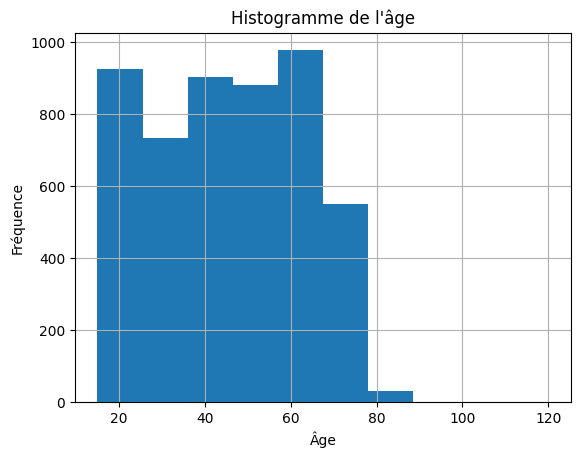

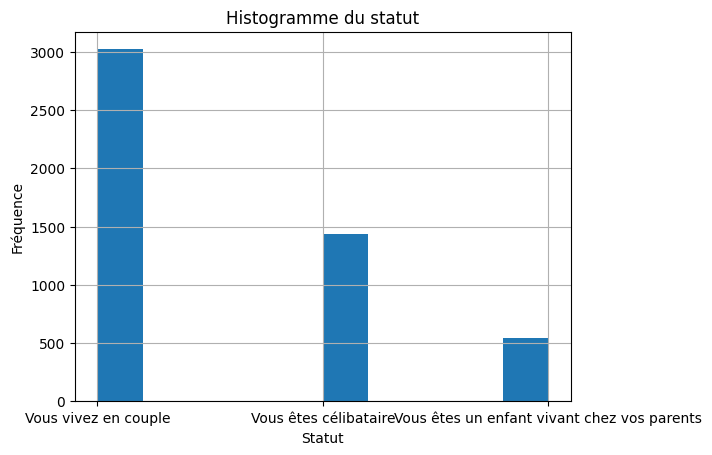

In [2]:

df["age"].hist()
plt.title("Histogramme de l'âge")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

df["statut"].hist()
plt.title("Histogramme du statut")
plt.xlabel("Statut")
plt.ylabel("Fréquence")
plt.show()

array(['LOIRE', 'LOIREATLANTIQUE', 'HAUTESAONE', 'PYRENNEESATLANTIQUES',
       'GARD', 'MORBIHAN', 'LOIRET', 'SEINEMARITIME', 'OISE', 'DORDOGNE',
       'GIRONDE', 'YVELINES', 'HAUTESPYRENNEES', 'MAINEETLOIRE',
       'HAUTSDESEINE', 'VALDEMARNE', 'HAUTEGARONNE', 'RHONE',
       'LOTETGARONNE', 'SARTHE'], dtype=object)

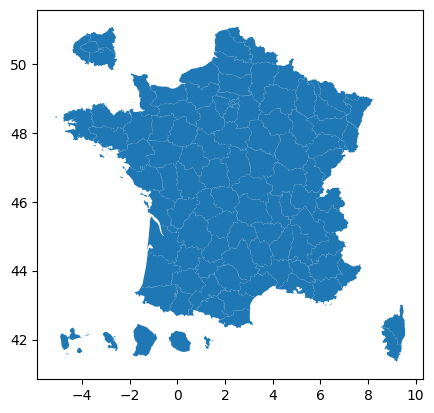

In [ ]:
departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements.plot()

df["departement"].unique()[:20]

departements = [
    "AIN","AISNE","ALLIER","ALPESDEHAUTESPROVENCE","HAUTESALPES",
    "ALPESMARITIMES","ARDECHE","ARDENNES","ARIEGE","AUBE","AUDE",
    "AVEYRON","BOUCHESDURHONE","CALVADOS","CANTAL","CHARENTE",
    "CHARENTEMARITIME","CHER","CORREZE","CORSES","COTEOR",
    "COTEDARMOR","CREUSE","DORDOGNE","DOUBS","DROME","EURE",
    "EUREETLOIRE","FINISTERE","GARD","HAUTEGARONNE","GERS",
    "GIRONDE","HERAULT","ILLEETVILAINE","INDRE","INDREETLOIRE",
    "ISERE","JURA","LANDES","LOIRTCHER","LOIRE","HAUTELOIRE",
    "LOIREATLANTIQUE","LOIRET","LOT","LOTETGARONNE","LOZERE",
    "MAINEETLOIRE","MANCHE","MARNE","HAUTEMARNE","MAYENNE",
    "MEURTHEETMOSELLE","MEUSE","MORBIHAN","MOSELLE","NIEVRE",
    "NORD","OISE","ORNE","PASDECALAIS","PUYDEDOME",
    "PYRENNEESATLANTIQUES","HAUTESPYRENNEES","PYRENNEESORIENTALES",
    "BASRHIN","HAUTRHIN","RHONE","HAUTESAONE","SAONEETLOIRE",
    "SARTHE","SAVOIE","HAUTESAVOIE","PARIS","SEINEMARITIME",
    "SEINEETMARNE","YVELINES","DEUXSEVRES","SOMME","TARN",
    "TARNETGARONNE","VAR","VAUCLUSE","VENDEE","VIENNE",
    "HAUTEVIENNE","VOSGES","YONNE","BELFORT","ESSONNE",
    "HAUTSDESEINE","SEINESAINTDENIS","VALDEMARNE","VALDOISE"
]

departement_num = {
    dep: i+1
    for i, dep in enumerate(sorted(departements))
}

df["dpt"] = df["departement"].map(departement_num)





EPSG:4326


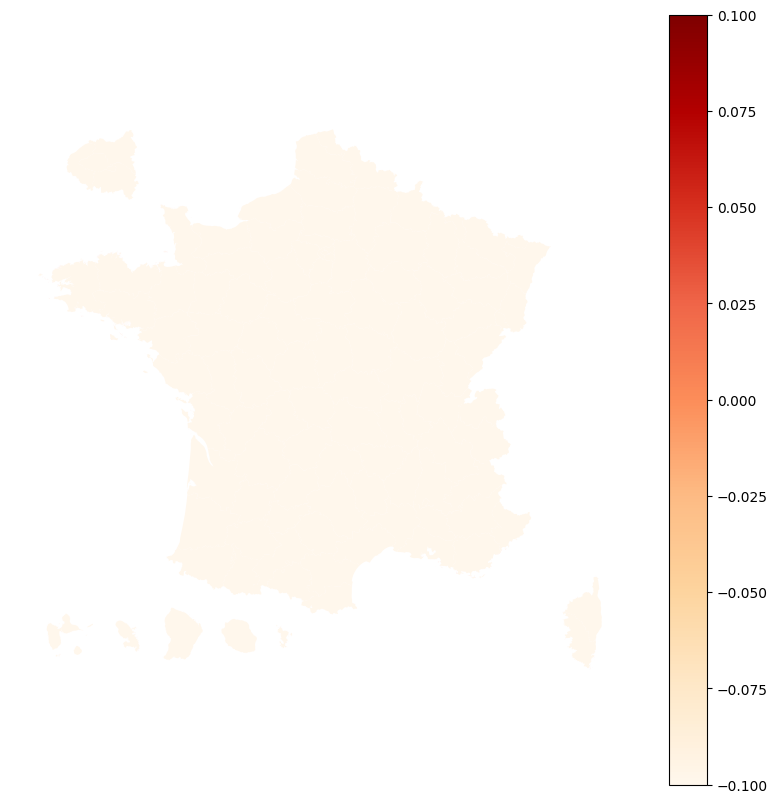

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Vérif CRS
print(departements.crs)

# Jointure
departements_merged = departements.merge(
    count_dep,
    left_on="INSEE_DEP",
    right_on="code_dep",
    how="left"
)

departements_merged["nb_reponses"] = departements_merged["nb_reponses"].fillna(0)

# Recast GeoDataFrame (clé 🔑)
departements_merged = gpd.GeoDataFrame(
    departements_merged,
    geometry="geometry",
    crs=departements.crs
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
departements_merged.plot(
    column="nb_reponses",
    cmap="OrRd",
    legend=True,
    ax=ax
)

ax.axis("off")
plt.show()

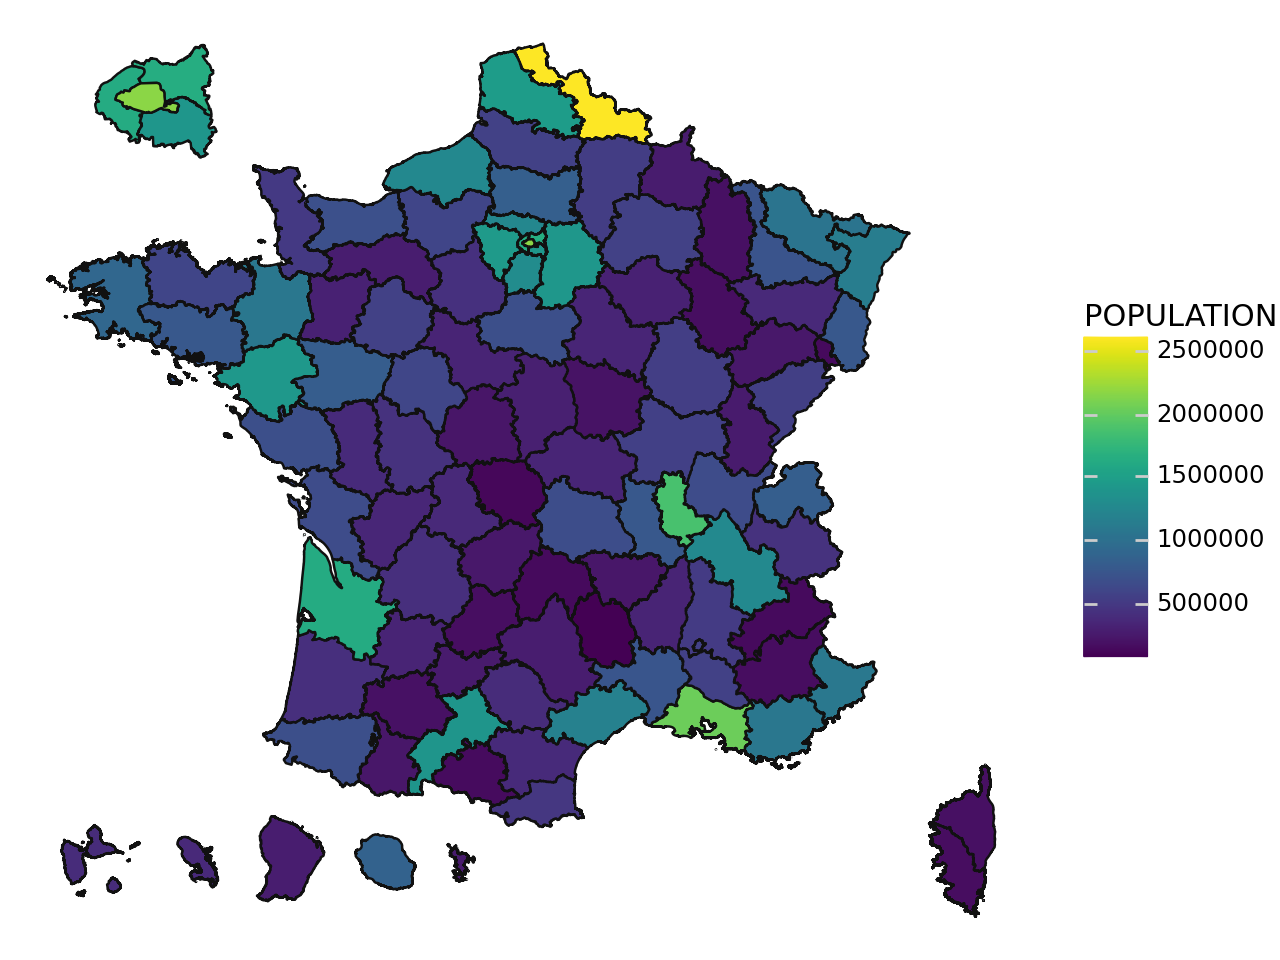

In [19]:
from plotnine import *

# Question 1
map1 = (
  ggplot(departements) +
  geom_map(aes(fill = "POPULATION")) +
  theme_void()
)

map1 